In [30]:
import pandas as pd
import json
import numpy as np
import sklearn
import scipy
import sys
import matplotlib.pyplot as plt
from pylab import *

from sklearn.utils.graph import graph_laplacian
from sklearn.utils.arpack import eigsh


pd.set_option('display.max_columns', 500)
%matplotlib inline

ModuleNotFoundError: No module named 'shaply'

In [2]:
#load affinity_matrix if we have it
#affinity_matrix = scipy.sparse.load_npz('../Data/ProcessingData/k_10_nearest_affenity_matrix_csc.npz')

In [2]:
#progress bar decorator
def log_progress(sequence, every=None, size=None):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display
    
    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = size / 200     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)
    
    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{index} / ?'.format(index=index)
                else:
                    progress.value = index
                    label.value = u'{index} / {size}'.format(
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = str(index or '?')

In [3]:
places = pd.read_csv("../Data/ProcessingData/places_36N.csv")
checkins = pd.read_csv("../Data/ProcessingData/chekins.csv")

#### Матрица взимодействия
from_lat, from_lng, to_lat, to_lng, wight

записываем в матрицу только если между заведениями больше n общих пользователей



In [4]:
places.head(1)

,address,checkins,city,country,created,distance,group_id,group_phot,icon,latitude,longitude,pid,place_id,title,type,updated,xcoord,ycoord
0,пр. Ветеранов 170,51,NaN,NaN,1429878167,313,NaN,NaN,https://vk.com/images/places/place.png,59.833544,30.136203,11659767,11659767,"Парк ""Сосновая поляна""",21,1516470339.0,339495.371421,6.636343e+06


In [5]:
places.shape

(6491, 18)

In [6]:
users_in_places = pd.merge(places, checkins, on='place_id', how='left')

In [7]:
def to_set(x):
    return set(x)

place_users = users_in_places.groupby('place_id')['uid'].agg({'size': len, 'users_set': to_set}).reset_index()

C:\Users\Artem\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.


In [53]:
place_users.head()

,place_id,size,users_set
0,74,4.0,"{153745289.0, 164370402.0, 546236.0, 264157.0}"
1,202,18.0,"{67011.0, 1159460.0, 171495.0, 154922026.0, 16..."
2,204,57.0,"{792320.0, 1113985.0, 22821891.0, 220298.0, 10..."
3,237,43.0,"{20897800.0, 90889.0, 19393554.0, 148259865.0,..."
4,245,5.0,"{447752.0, 9773961.0, 133114189.0, 2697846.0}"


In [15]:
join_list = []

i = 1

for row in log_progress(place_users.iterrows(),1):
    for row_2 in place_users.iloc[i:].iterrows():
        join_set = row[1]['users_set'] & row_2[1]['users_set']
        if len(join_set) > 2:
            join = {'place_from_id': row[1]['place_id'], 'place_to_id': row_2[1]['place_id'], 'common_users_set': join_set, 'size': len(join_set)}
            join_list.append(join)
            
    i+=1

In [17]:
len(join_list)

62410

In [18]:
#add coord
join_df = pd.DataFrame(join_list)

In [19]:
from_df = pd.merge(join_df[['place_from_id', 'place_to_id', 'size',]], places[['place_id', 'latitude', 'longitude', 'xcoord', 'ycoord', 'title']], left_on='place_from_id', right_on='place_id', how='left')

In [22]:
from_df = from_df.rename(index=str, columns={"latitude": "from_lat", "longitude": "from_lng", "xcoord": "from_x", "ycoord": "from_y", 'title':'from_title' })

In [23]:
from_df.head()

,place_from_id,place_to_id,size,place_id,from_lat,from_lng,from_x,from_y,from_title
0,204,5883,3,204,59.938982,30.327281,350674.468152,6.647631e+06,Акакао
1,204,4564617,3,204,59.938982,30.327281,350674.468152,6.647631e+06,Акакао
2,204,4589220,3,204,59.938982,30.327281,350674.468152,6.647631e+06,Акакао
3,204,5363074,3,204,59.938982,30.327281,350674.468152,6.647631e+06,Акакао
4,204,5439777,4,204,59.938982,30.327281,350674.468152,6.647631e+06,Акакао


In [24]:
to_df = pd.merge(from_df, places[['place_id', 'latitude', 'longitude', 'xcoord', 'ycoord', 'title']], left_on='place_to_id', right_on='place_id', how='left')

In [27]:
final_df = to_df.rename(index=str, columns={"latitude": "to_lat", "longitude": "to_lng", "xcoord":"to_x", "ycoord":"to_y", "title":"to_title"})

In [28]:
final_df.head()

,place_from_id,place_to_id,size,place_id_x,from_lat,from_lng,from_x,from_y,from_title,place_id_y,to_lat,to_lng,to_x,to_y,to_title
0,204,5883,3,204,59.938982,30.327281,350674.468152,6.647631e+06,Акакао,5883,59.942385,30.335766,351163.612025,6.647991e+06,Летний сад
1,204,4564617,3,204,59.938982,30.327281,350674.468152,6.647631e+06,Акакао,4564617,59.931977,30.354621,352170.239136,6.646790e+06,Grizzly Bar Saint-Petersburg
2,204,4589220,3,204,59.938982,30.327281,350674.468152,6.647631e+06,Акакао,4589220,59.919343,30.350540,351885.950880,6.645393e+06,МОДНЫЙ КЛУБ ГРИБОЕДОВ
3,204,5363074,3,204,59.938982,30.327281,350674.468152,6.647631e+06,Акакао,5363074,59.981436,30.200782,343809.675592,6.652648e+06,Парк 300- летия
4,204,5439777,4,204,59.938982,30.327281,350674.468152,6.647631e+06,Акакао,5439777,59.919336,30.464995,358282.229463,6.645141e+06,Ледовый дворец


In [31]:
distance_list = []
for row in log_progress(final_df.iterrows(),1):
    data = row[1]
    distance = math.sqrt((data['from_x']-data['to_x'])**2 + (data['from_y']-data['to_y'])**2)
    distance_list.append(distance)

In [33]:
final_df['distance'] = distance_list

In [35]:
final_df.to_csv('livehoods_arc.csv')

In [16]:
users = checkins.drop_duplicates('uid').reset_index()

uid_index = {}
for u in log_progress(users.iterrows(),100):
    uid_index[u[1].uid] = u[0]

VBox(children=(HTML(value=''), IntProgress(value=1, bar_style='info', max=1)))

In [17]:
uniq_places = places.drop_duplicates('place_id').reset_index()

place_index = {}
for p in log_progress(uniq_places.iterrows(), 1000):
    place_index[p[1].place_id] = p[0]

VBox(children=(HTML(value=''), IntProgress(value=1, bar_style='info', max=1)))

In [19]:
#place checkins matrix - "bag_of_users"
checkins_with_pid = checkins.merge(places[['place_id','title']], how='inner', on='place_id')
checkin_group_by_pid = checkins_with_pid.groupby(['place_id','uid'])['post_id'].count()
                                  
bag_of_users = scipy.sparse.lil_matrix((len(uniq_places), len(users)), dtype=int16)

for g in log_progress(checkin_group_by_pid.iteritems(),100):
    pid = g[0][0]
    uid = g[0][1]
    
    local_pid = place_index[pid]
    local_uid = uid_index[uid]
    
    bag_of_users[local_pid, local_uid] = g[1]

VBox(children=(HTML(value=''), IntProgress(value=1, bar_style='info', max=1)))

In [20]:
#kd-tree
places_lat = uniq_places.xcoord.tolist();
places_lng = uniq_places.ycoord.tolist();

coords_list = []
for i in range(0,len(places_lat)):
    coords_list.append([places_lat[i], places_lng[i]])

location = np.array(coords_list)

tree = sklearn.neighbors.KDTree(location, leaf_size=2)

In [21]:
places_count = len(uniq_places)

k_10_nearest_affinity_matrix = scipy.sparse.lil_matrix((places_count,places_count), dtype=float64)
for j in log_progress(range(0, places_count), 10):
    ind = tree.query([location[j]], k = 10, return_distance = False)
    
    for k in ind[0]:
        if k != j:
            social_distance = sklearn.metrics.pairwise.cosine_similarity(bag_of_users[j], bag_of_users[k]) + 0.001
                
            k_10_nearest_affinity_matrix[j,k] = social_distance

VBox(children=(HTML(value=''), IntProgress(value=0, max=6491)))

In [22]:
in_500m_nearest_affinity_matrix = scipy.sparse.lil_matrix((places_count,places_count), dtype=float64)

for j in log_progress(range(0, places_count),10):
    
    ind = tree.query_radius([location[j]], r=500)
    
    for k in ind[0]:
        if k != j:
            
            social_distance = sklearn.metrics.pairwise.cosine_similarity(bag_of_users[j], bag_of_users[k]) + 0.001
                
            in_500m_nearest_affinity_matrix[j,k] = social_distance  

VBox(children=(HTML(value=''), IntProgress(value=0, max=6491)))

In [23]:
k_10_nearest_affinity_matrix_csc = k_10_nearest_affinity_matrix.tocsc()
scipy.sparse.save_npz('k_10_nearest_affinity_matrix_csc.npz', k_10_nearest_affinity_matrix_csc)

In [28]:
#similarity graph in geojson
similarity = []

affinity_matrix = k_10_nearest_affenity_matrix_csc

for i in log_progress(range(0,  affenity_matrix.shape[0]),10):
    #sim = {"start_lat":0.0, "start_lng":0.0, "end_lat":0.0, "end_lng":0.0, "similarity":0.0}
    
    nonzero_indexes = affinity_matrix[i].nonzero()[1]
    start_venues = places.iloc[i]
    for j in nonzero_indexes:
        sim = {}
        
        end_venues = places.iloc[j]
        
        sim['start_lat'] = start_venues['latitude']
        sim['start_lng'] = start_venues['longitude']
        sim['start_place'] = start_venues['title']
        sim['end_lat'] = end_venues['latitude']
        sim['end_lng'] = end_venues['longitude']
        sim['end_place'] = end_venues['title']
        sim['similarity'] = affenity_matrix[i,j]
        
        similarity.append(sim)

VBox(children=(HTML(value=''), IntProgress(value=0, max=6491)))

In [29]:
gejson_schema = {
    "type": "FeatureCollection",
    "name": "sim_test",
    "crs": { "type": "name", "properties": { "name": "urn:ogc:def:crs:OGC:1.3:CRS84" } },
    "features": [
    { "type": "Feature", "properties": { "similarity": e['similarity'], "start_place":e['start_place'], "end_places":e['end_place']}, "geometry": { "type": "LineString", "coordinates": [ [ e['start_lat'], e['start_lng'] ], [ e['end_lat'], e['end_lng']] ] } }
    for e in similarity]
}

In [30]:
import json
with open('similarity_graph_join.geojson', 'w') as fp:
    json.dump(gejson_schema, fp)

In [8]:
laplacian = scipy.sparse.csgraph.laplacian(affinity_matrix, normed=True)
n_components = affinity_matrix.shape[0] - 1
eigenvalues, eigenvectors = eigsh(-laplacian, k=n_components, which="LM", sigma=1.0, maxiter=5000)

eigenvalues = -eigenvalues[::-1]  # Reverse and sign inversion.

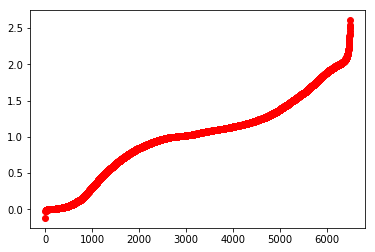

In [42]:
plt.plot(eigenvalues, 'ro')
plt.show()

In [29]:
eigngaps = []
for i in range(0,len(eigenvalues)-1):
    k = eigenvalues[i+1] - eigenvalues[i]
    eigngaps.append((i,k))

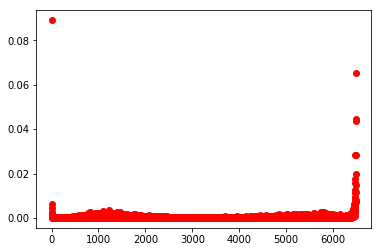

In [41]:
plt.plot(list(map(lambda x: x[1], eigngaps)), 'ro')

In [ ]:
eigngaps.sort(key=lambda x: x[1])

In [7]:
# 0 ,1, 2, 4, 9, 17, 18, 22, 28, 44, 152, 270
k_list = [2, 4, 9, 17, 18, 22, 28, 44, 152, 270]
for k in k_list: 
    classter_method = sklearn.cluster.SpectralClustering(n_clusters=k, affinity='precomputed', assign_labels="kmeans").fit(affinity_matrix)
    labels = classter_method.labels_
    places['labels'] = labels
    places.to_csv('../Data/CleanData/labeled_places_k_{}.csv'.format(str(k)))

C:\Users\Artem\Anaconda3\lib\site-packages\sklearn\utils\validation.py:640: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  warnings.warn("Array is not symmetric, and will be converted "
